## Spacenet

300x300 sized images - instead of 900 x 900


Nadir: 0-25 degrees Off-nadir: 26 degrees - 40 degrees Very Off-nadir 41-55 degrees

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid

In [3]:
import PIL.Image as pil_image

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from fastai.utils import *
import fastai
print(fastai.__version__)

1.0.36.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
print(f'DATE: {DATE}') 

DATE: 20181215


In [8]:
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}') 

UID: 93a39b17


In [9]:
ARCH = models.resnet34
ARCH_NAME = 'rn34'
MODEL_NAME = 'high_lr_300_unet_mid'

## Load Data

In [10]:
#using HD here
path = Path('../../data/SpaceNet_Off-Nadir_Dataset')
path.ls()

[PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Test'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_data'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/band-triplets.txt'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample.tar.gz'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_rgb'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/train_rgb'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_test'),
 PosixPath('../../da

In [11]:
path_img = path/'resized_train_300'
path_lbl = path/'resized_masks_300'
path_test = path/'resized_test_300'

In [12]:
fanames = get_image_files(path_img)
lbla_names = get_image_files(path_lbl)
fanames[:3], lbla_names[:3] 

([PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir19_catid_1030010003C92000_740801_3734589_g_0.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir46_catid_1030010003713C00_747551_3723339_g_6.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_748451_3727389_g_7.png')],
 [PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_734051_3741789_g_0.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_748451_3741789_g_2.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_741251_3742239_g_0.png')])

In [14]:
#subset names based on angle
fnames=[]
for aname in fanames:
    apts = str(aname.name).split('_')
    nadir = apts[2]
    angle = int(nadir.split('nadir')[1])
    if 25 < angle <= 40:
        fnames.append(aname)
        

In [16]:
len(fnames)

67032

In [17]:
def get_y_fn(full_name):
    parts = str(full_name).split('_')
    im_id = '_'.join(parts[-4:])
    mask_name = 'mask_'+im_id
    return path_lbl/f'{mask_name}'

In [18]:
#problem image/mask match:

#739001_3724239

In [19]:
img_f = fnames[-1]
img = open_image(img_f)
mask_f = get_y_fn(img_f)
mask = open_mask(mask_f, div=True)
print(f'img: {img_f}, mask: {mask_f}')


img: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir32_catid_103001000392F600_742151_3739089_g_6.png, mask: ../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_742151_3739089_g_6.png


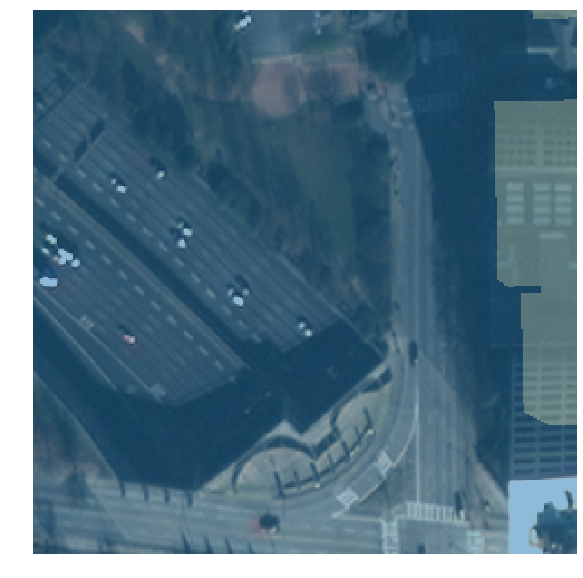

In [20]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [21]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[300 300]


tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# Make DataBunch

In [22]:
size = src_size
bs=4

In [23]:
#holdout_grids = ['735851','747551','741251','746201']
#valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [24]:
codes = np.array(['offnadir'])

In [25]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [26]:
src = (SegItemListCustom.from_folder(path_img)
        #.split_by_idx(valid_idx)
        .random_split_by_pct(0.1)
        .label_from_func(get_y_fn, classes=codes))

In [27]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [28]:
data

ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (232697 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (232697 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Valid: LabelList
y: SegLabelListCustom (25855 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (25855 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Test: None

In [29]:
data.valid_ds.items

array([PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir39_catid_1030010003832800_741701_3727389_g_6.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir42_catid_10300100035D1B00_732701_3725139_g_6.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir13_catid_1030010002B7D800_748001_3730089_g_4.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir32_catid_103001000392F600_743501_3721539_g_8.png'),
       ...,
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir30_catid_10300100036D5200_747101_3727839_g_8.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC100_742151_3720189_g_4.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharp

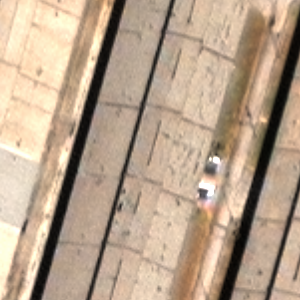

In [30]:
data.train_ds.x[1]

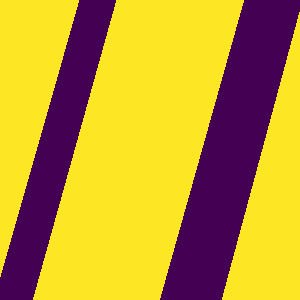

In [31]:
data.train_ds.y[1]

In [32]:
data.train_ds.y[1].data

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])

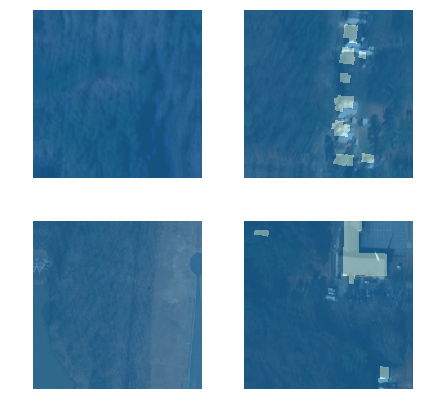

In [33]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

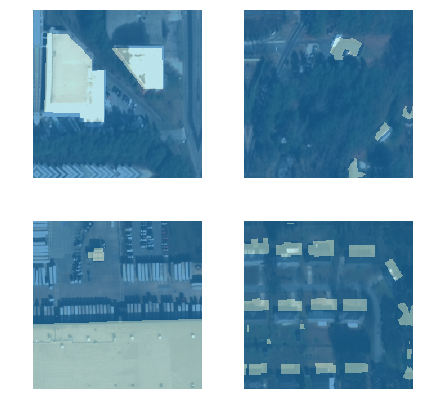

In [34]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

In [35]:
data.classes

array(['offnadir'], dtype='<U8')

In [36]:
#### export for later use

In [38]:
data.export(fname=f'{DATE}_{UID}_{MODEL_NAME}_export.pkl')

# Custom Loss

In [39]:
import pdb

In [40]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [41]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [42]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_thresh, dice]

In [43]:
learn = unet_learner(data, ARCH, metrics=metrics)

In [44]:
learn.loss_func

In [45]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [46]:
# learn.opt_func = partial(optim.SGD,momentum=0.9)

In [47]:
learn.lr_find()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch-nightly_1543485201286/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [ ]:
learn.recorder.plot(0,0)

In [72]:
lr = 1e-3

In [73]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [74]:
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.596462,0.545345,0.380955,0.941470,0.616462
2,0.613135,0.524652,0.363640,0.943661,0.626424
3,0.528369,0.505905,0.349773,0.942469,0.618478
4,0.524638,0.507871,0.350310,0.941439,0.630678
5,0.511634,0.464930,0.323009,0.948149,0.664692


In [75]:
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-stage-1-{UID}')

In [76]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-stage-1-{UID}')


Learner(data=ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (232697 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (232697 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Valid: LabelList
y: SegLabelListCustom (25855 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (25855 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Test: None, model=DynamicUnet(
  (

In [77]:
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.557642,0.507839,0.353885,0.944466,0.614216
2,0.576474,0.512195,0.355402,0.944082,0.628230
3,0.509375,0.484023,0.337141,0.946303,0.652165
4,0.528431,0.478042,0.330643,0.945923,0.662108
5,0.480974,0.456727,0.317530,0.949412,0.670425


In [78]:
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-stage-2-{UID}')

In [79]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-stage-2-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (232697 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (232697 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Valid: LabelList
y: SegLabelListCustom (25855 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (25855 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Test: None, model=DynamicUnet(
  (

In [80]:
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [81]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [82]:
outputs.shape

torch.Size([4, 3, 300, 300])

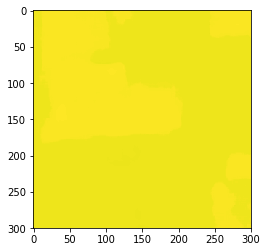

In [83]:
plt.imshow((to_np(outputs[2][1])))

In [84]:
outputs[2][1].sigmoid()

tensor([[4.7164e-03, 6.2674e-03, 4.9318e-03,  ..., 9.9974e-01, 9.9942e-01,
         9.9963e-01],
        [7.5654e-03, 9.8745e-03, 5.0184e-03,  ..., 9.9961e-01, 9.9917e-01,
         9.9910e-01],
        [3.7072e-03, 4.3209e-03, 2.9909e-03,  ..., 9.9971e-01, 9.9945e-01,
         9.9953e-01],
        ...,
        [1.8942e-03, 3.4038e-03, 1.2430e-03,  ..., 6.1458e-01, 6.5833e-01,
         6.1921e-01],
        [1.6796e-32, 2.3904e-16, 3.4069e-03,  ..., 2.1927e-01, 2.8926e-01,
         4.2116e-01],
        [0.0000e+00, 0.0000e+00, 7.2782e-04,  ..., 3.5477e-03, 3.7571e-02,
         2.9592e-01]])

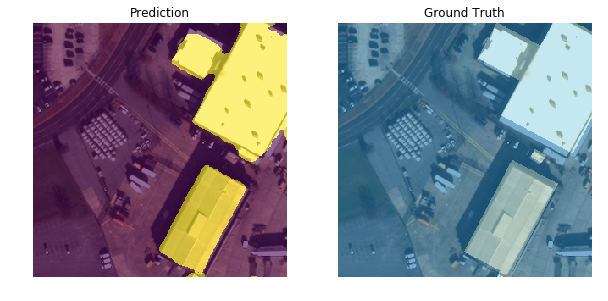

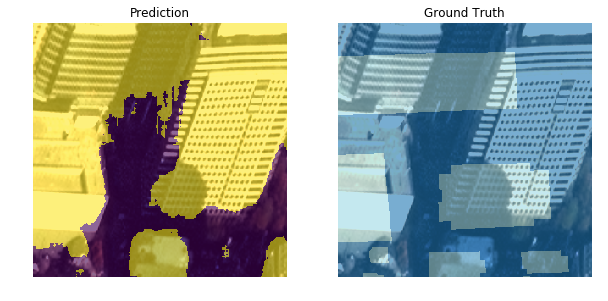

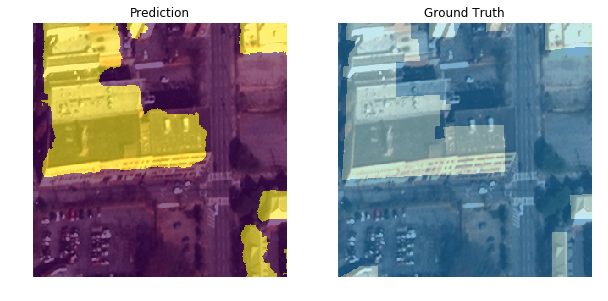

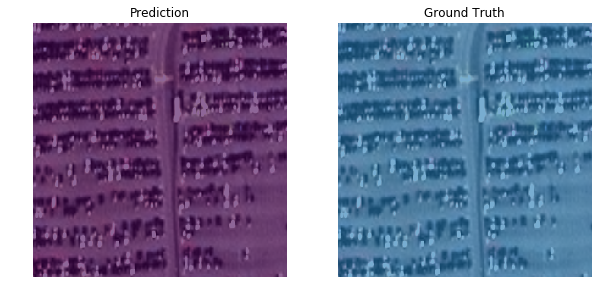

In [85]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

## Unfreeze and Train More

In [86]:
learn.model.train()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [87]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


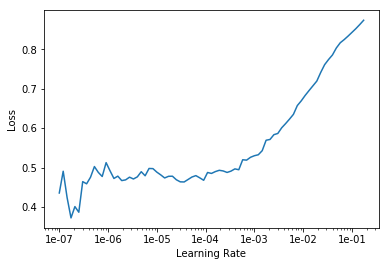

In [88]:
learn.recorder.plot(0,0)

In [89]:
lr = 1e-3

In [90]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,lr/10))

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.499984,0.449135,0.312455,0.950135,0.648695
2,0.493305,0.455288,0.315903,0.949311,0.671594
3,0.466216,0.446300,0.312058,0.950502,0.669751
4,0.507100,0.438682,0.305738,0.951357,0.676724
5,0.479719,0.439036,0.305829,0.951172,0.681357


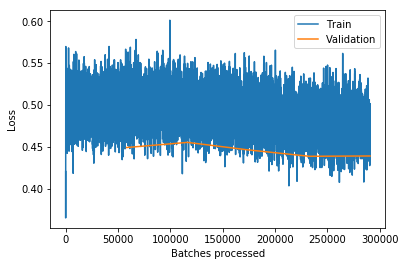

In [91]:
learn.recorder.plot_losses()

In [92]:
#save model after these n epochs
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-stage-3-{UID}')
        

In [93]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,lr/10))

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.494642,0.439083,0.307457,0.951617,0.680119
2,0.478211,0.445482,0.310258,0.951001,0.672131
3,0.502286,0.436623,0.305808,0.951886,0.671778
4,0.484292,0.428968,0.299731,0.952577,0.669200
5,0.467431,0.424795,0.296876,0.953056,0.684640


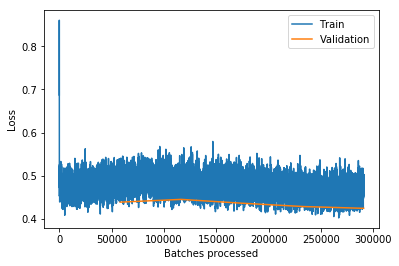

In [94]:
learn.recorder.plot_losses()

In [95]:
#save model after these n epochs
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-stage-4-{UID}')

In [96]:
outputs = learn.get_preds(ds_type=DatasetType.Valid)

RuntimeError: CUDA out of memory. Tried to allocate 131.88 MiB (GPU 1; 10.92 GiB total capacity; 8.39 GiB already allocated; 101.50 MiB free; 1.13 GiB cached)

In [ ]:
outputs[0][0][1].squeeze(0).shape

In [ ]:
plt.imshow((to_np(outputs[0][0][1].squeeze(0))))

In [ ]:
outputs[0][0][1].squeeze(0).sigmoid()

In [ ]:
for i in range(bs*2):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[0][i][1].squeeze(0).sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [ ]:
for i in range(bs*2):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[0][i][1].squeeze(0).sigmoid())), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [97]:
data.export(fname=f'{DATE}_{UID}_{MODEL_NAME}_export.pkl')